# Methodologies for image processing of radar remote sensing data #
## Lecture 3. Empirical Analyses (Exercise) ##
### Shiyi Li ###

## Introduction ##
This execrise aims at deepening the knowledge about hypotheses testing. By finishing this exercise, you should be able to:

1. Understand the concept of hypothesis testing
2. Design hypothesis testing for simple image segmentation problem
3. Identify type I error and type II error, and interprete the result 
4. Identify significance level and probability of detection, and identify their influence on results.

In the exercise, you will be asked to examine a SAR image of Zurich, and perform hypothesis testing to discriminate water body and non-water body in the image. The SAR images are acquired by Sentinel-1 at 2019-10-04 [1].

**To run a cell, first select it. Then, you can either click the "Run" button above the notebook, or press ctrl + Enter on your keyboard.**

**Other useful buttons:**

* Under "File", you can download the notebook as PDF(only for view) or notebook(to edit & run). This enables you to save your work from the online host.

* Under "Kernel", you can choose to interrupt a code or restart the kernel. This can save you from a dead code.

* In the middle of the toolbar, you can change the cell type by choosing in the Drop-down menu. A cell code is to write python code, and a markdown cell is to write document.

* To quickly delete a cell, click the white space on the left of the cell, then double click "D" on your keyboard.

In [1]:
# Load necessary packages
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
from rasterio.plot import show
from rasterio.windows import Window
from scipy.stats import norm
from matplotlib.patches import Rectangle
from IPython.display import display, Latex, HTML
import matplotlib.ticker as mtick
import cv2
# make sure cv2 is loaded.
print(cv2.__version__)

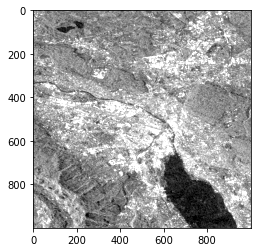

In [2]:
# Read in the SAR img
# In the filename, change 'vv' to 'vh' to import
# SAR image of diifferent polarimetry channel

imgfile = Path('s1a_vv_20191004_zurich.tif')

with rasterio.open(imgfile, 'r') as src:
    img = src.read(1)
    img_meta = src.profile
    
# convert image into dB for plot
plt.imshow(np.log10(img), cmap='gray', vmin=1.8, vmax=2.8)
plt.show()

In [ ]:
# Uncomment the following lines to apply Gaussian filter (see part-3)
# You are encouraged to change the filter properties 

# filter_width = (25, 25)
# filter_std = 9
# img = cv2.GaussianBlur(img, filter_width, filter_std)

## 1. Build statitical model of the pixel value on water surface

The first step is to observe the distribution of pixel values on water area and non-water area, then we can build a statistical model to describe the pixel value distribution.. 

We assume that the pixel value of the water area follows a Normal distribution. To construct the model, we need to know the mean($\mu$) and standard deviation ($\sigma$) of the Normal distribution.

The following function may help you check the histogram of pixel values in a region of interest (ROI). 

In [3]:
def check_hist_region(win, img, figsize=[10, 5], hist_bin=100, xrange=None):
    
    """
    Examine the histogram of the region of interest (ROI).
    
    The function takes the ROI window and raw sar image as input and
    display the histogram of the ROI, as well as the fitted PDF.
    
    Parameters
    ----------
    win : tuple
        The ROI window, defined as (row_start, col_start, width, height)
    img : numpy array
        The full image from which the ROI is taken
    figsize : list or tuple, optional
        The size of figure for plot, (default is [10, 5])    
    hist_bin : int, optional
        The bins of the histogram
    xrange : uple or None, optional
        The lower and upper range of the bins. Lower and upper outliers are ignored. If not provided, range is (x.min(), x.max()). 
        Range has no effect if bins is a sequence.
        
    Return
    ----------
    zone: the ROI array
    mu: the mean of the estimated normal distribution
    std: the standard deviation of the estimated normal distribution
    """
    
    y, x, w, h = win
    zone = img[y:y+h, x:x+w]
    
    zone_flat = zone.ravel() #flatten the 2d array
    mu, std = norm.fit(zone_flat)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # define plot parameters for the histogram
    hist_param = dict(density=True, color='#0504aa',alpha=0.7, rwidth=0.85)
    
    density, bins, _ = ax1.hist(zone_flat, bins=hist_bin, range=xrange, **hist_param)
    
    # fit a normal distribution PDF
    _x = (bins[0:-1] + bins[1:]) / 2
    p = norm.pdf(_x, mu, std)
    l = ax1.plot(_x, p, 'r--', linewidth=2)
    
    text_str = r'$\mu = %.2f$' % mu + '\n' + '$\sigma^2 = %.2f$' % std
    ax1.text(0.9, 0.9, text_str, ha='right', va='top', fontsize=12, transform=ax1.transAxes)
    show(np.log10(img), cmap='gray', ax=ax2, vmin=1.5, vmax=3)
    
    # Create a Rectangle patch
    rect = Rectangle(xy=(x, y), width=w, height=h, linewidth=1, ec='r', fc='none')
    ax2.add_patch(rect)
    
    ax2.grid('True')
    
    plt.show()
    
    return zone, mu, std

**Tasks:**

1. Use the above function to check the histogram of pixels falling in Zurich Lake. 

2. Change the roi_window to detect different regions. 

3. Compare the histogram of water body and non-water boday, notice the difference in between. 

4. Try different window size to conclude a statistical model that describes the pixel value distribution on water, note down the model parameters ($\mu$, $\sigma^2$) for hypothesis testing.

In [ ]:
# window format: (row_start, col_start, width, height)
roi_window = (850, 710, 50, 60) 

# If you are looking at non-water area, it is
# better to specify a limited range (i.e. xrange=(0, 1000)).
xrange = None

roi, _mu, _std = check_hist_region(roi_window, img, xrange=None)

## 2. Perform hypothesis testing to discriminate water and non-water

In step-1, we built up a statistical model that describes the pixel value distribution of water body. 

To perform the hypothesis testing, we need to:

- make the hypothesis statements
- choose a proper threshold
- calculate the probability of the pixel value given the null hypothesis is true.
- accept or reject the hypothesis 

### 2.1 Hypothesis statement and choose threshold

**Task: Make your hypothesis statements ($H_0$ and $H_1$) before continuing.**

In [ ]:
# Build your statistical model by filling up the parameters 
mu = 82
std = 25

# Define the threshold, in percent 
# you dont have to convert percentage into decimal 
# i.e. 0.05 here indeed represents 0.05% (0.0005)

alpha = 0.05 

*Uncomment the following code to see the statement I made:*

In [ ]:
# H0_state = r"$H_0$: The given pixel is on a water-body i.e. the pixel value follows $\mathcal{N}(\mu=%.2f, \sigma^2=%.2f)$ ." % (mu, std)
# H1_state = r"$H_1$: The given pixel is NOT on a water-body i.e. the pixel value does NOT follow $\mathcal{N}(\mu=%.2f, \sigma^2=%.2f)$ ." % (mu, std)

# display(Latex(H0_state))
# display(Latex(H1_state))

### 2.2 calculate the probability and make a decision

Now that we have the hypotheses ready, we can calculate the probability of every pixel in the image assuming the null hypothesis is true.

Based on the probability, we can decide to accept or reject the null hypothesis.

The function below can help you do the calculation.

In [ ]:
def hypo_test_water(arr, h0=(82, 25), alpha=0.05):
    
    """
    Perform hypothesis testing on each element of a given array.
    
    Parameters
    ----------
    arr : numpy array
        The array whose element is tested
    h0 : tuple, optional
        The parameter of h0 statement in (mu, std), (default is (82, 25))
    alpha : float, optional
        The threshold based on which the hypothesis is accepted or rejected
        
    Return:
    ----------
    segment: the segmented image, whose values are either 0 - accept H0 or 1 - reject H0
    pdf_distr: the propability of each element in the image assuming H0 is true
    """
    
    shape = arr.shape
    mu, std = h0
    
    # calulate pdf of each pixel given the statistic model 
    pdf = norm.pdf(arr.ravel(), mu, std)
    
    pdf_distr = np.reshape(pdf, shape)
    
    # accept if the pdf is higher than the threshold
    segment = (pdf_distr > alpha/100).astype(int)
    
    return segment, pdf_distr

**Task**:

1. Run hypotheses test using the given function and your statistical model, generate the segmentation map and the probability map (see below).
2. Interpret the segmentation map: 
    * Are all water bodies correctly discriminated?
    * Do you observe type-I error and type-II error? You can copy the map into Paint and mark the region of two types of error. 
3. Change alpha and observe the change of the result. Interprete the changes in terms of significance level.
4. Change the statistical model (e.g. modify mu or std) and observe the change of the result. Interprete the changes in terms of probability of detection.

*Hint: For question 4, think about the statistical model of non-water body. We did not estimate the distribution of pixel values in non-water area yet, but you can use the function in step-1 to analyze it (add a range (0~1000) might be necessary). Draw a scratch of the statistical model of H0 and H1, then analyze how the change of H0 affects the probability of detection.*

In [ ]:
# Change the statistical model parameter (mu, std) or alpha 
# will change the segmentation result.

seg, pdf = hypo_test_water(img, h0=(mu, std), alpha=alpha)

# Plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im = ax1.imshow(seg, cmap='gray')
ax1.set_title('Segmentation\n(white=water, black=non-water)')
plt.colorbar(im, ax=ax1, shrink=0.75)

im = ax2.imshow(pdf, cmap='viridis')
ax2.set_title('Probability of pixels \nassuming H0 is true.')
plt.colorbar(im, ax=ax2, shrink=0.75, format=mtick.FuncFormatter(lambda y, _: '{:.2f}%'.format(y*100)))

for ax in [ax1, ax2]:
    ax.axis('off')

plt.show()

### Step 3 (optional)

The result obtained above is not optimized. One common practice of improving the result is to apply filter to the images before running any analysis. 

Clear all the results and uncomment the 3rd code cell to apply Gaussian filter to the image. You can adapt he filter properties to make your result optimized. 

**Questions worth thinking about**:
* What changes do you observe in the histogram of pixel values? Why does these changes happen?
* What changes do you observe in your result? Interprete the changes in terms of type-I error/type-II error
* What changes do you observe towards the probability of detection ? Does the power of detection increase or decrease?

**Bonus**: Use SAR image of different channels to run the same test.

### Reference ###
[1] ASF DAAC 2019, contains modified Copernicus Sentinel data 2019, processed by ESA.